In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.init import xavier_uniform_ as init
from torch.autograd import Variable
import numpy as np

# prepare data

In [2]:
BATCH_SIZE=128
EPOCHS=20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

In [0]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=500, shuffle=True)

In [0]:
test_iter = iter(test_loader)
imgs,labels = next(test_iter)

In [6]:
print(imgs.shape,labels.shape)

torch.Size([500, 1, 28, 28]) torch.Size([500])


In [7]:
x_test = torch.tensor(imgs[:500],device=DEVICE,dtype=torch.float)
# x_test = x_test.view(x_test.size(0),1, x_test.size(1),x_test.size(2))
y_test = torch.tensor(labels[:500],device=DEVICE,dtype=torch.long)


print(x_test.shape, y_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([500, 1, 28, 28]) torch.Size([500])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


# Model

In [0]:
epsilon = 0.00000001
def squash(x):
    # not concern batch_size, maybe rewrite
    s_squared_norm = torch.sum(x*x,1,keepdim=True) + epsilon
    scale = torch.sqrt(s_squared_norm)/(1. + s_squared_norm)
    # out = (batch_size,1,10)*(batch_size,16,10) = (batch_size,16,10)
    out = scale * x
    return out

In [0]:
# A Capsule Implement with pytorch
class Capsule(nn.Module):

    def __init__(self, in_units,in_channels, num_capsule, dim_capsule, routings=3, **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.in_units = in_units
        self.in_channels = in_channels
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        # (in_units,10,128,16)
        self.W = nn.Parameter((torch.randn(self.in_units,self.num_capsule,self.in_channels, self.dim_capsule)))

    def forward(self, u_vecs):
        u_vecs = u_vecs.permute(0,2,1)
        u_vecs = u_vecs.unsqueeze(2)
        u_vecs = u_vecs.unsqueeze(2)

        
        # (batch_size,in_units,1,1,in_channels)*(in_units,10,in_channels,16) = (batch_size,in_units,10,1,16)
        u_hat_vecs = torch.matmul(u_vecs,self.W)
        # (batch_size,in_units,10,16)
        u_hat_vecs = u_hat_vecs.permute(0,1,2,4,3).squeeze(4)
        
        # (batch_size,10,in_units,16)
        u_hat_vecs2 = u_hat_vecs.permute(0,2,1,3)
    
        # (batch_size,10,1,in_units)
        b = torch.zeros(u_hat_vecs.size(0),self.num_capsule,1,self.in_units,device=DEVICE)
        for i in range(self.routings):
            # (batch_size,10,1,in_units)
            c = F.softmax(b,-1)
            # s = (batch_size,10,1,in_units)*(batch_size,10,in_units,16) = (batch_size,10,1,16)
            s = torch.matmul(c,u_hat_vecs2)
            # (batch_size,16,10)
            s = s.permute(0,3,1,2).squeeze(3)
            # (batch_size,16,10)
            v = squash(s)
            # here
            # (batch_size,10,16,1)
            v = v.permute(0,2,1).unsqueeze(3)
            # (batch_size,10,in_units,16)*(batch_size,10,16,1) = (batch_size,10,in_units,1)
            sim = torch.matmul(u_hat_vecs2,v)
            # (batch_size,10,1,in_units)
            sim = sim.permute(0,1,3,2)
            b = b+sim
        # (batch_size,16,10)
        return v.permute(0,2,1,3).squeeze(3)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x,label):
        # x (batch_size,10,16)
        # label (batch_size,10,1)
        label = label.unsqueeze(2)

        inp = label*x
        inp = inp.view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(inp)
        reconstructions = reconstructions.view(-1, 1, 28, 28)
        
        return reconstructions    
    
    
class CapsuleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1,28x28
        self.conv1=nn.Conv2d(1,256,9) 
        self.conv2=nn.Conv2d(256,32*8,9,2) 
        self.capsule = Capsule(1152,8, 10, 16)
        self.Decoder = Decoder()
   
#         self.fc2 = nn.Linear(500,10)
    def forward(self,x,label):
        batch_size = x.size(0)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        # (batch_size, 32*8, 6, 6)
        out = F.relu(out)
        out = out.view(batch_size,8,-1)
        out = squash(out)

        # (batch_size,8,1152)
        out = out.view(out.size(0),out.size(1),-1)
        # (batch_size,16,10)
        out = self.capsule(out)
        # (batch_size,10,16)
        out = out.permute(0,2,1)
        

        
        decoder = self.Decoder(out,label)

        


        return out,decoder

In [10]:
import os
model = CapsuleNet()
if os.path.exists('params.pkl'):
    model.load_state_dict(torch.load('params.pkl'))
    
model.to(DEVICE)

CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (capsule): Capsule()
  (Decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [11]:
optimizer = optim.Adam(model.parameters())#,lr=0.000001)

n_epoch = 7
pre_acc = 0
for epoch in range(n_epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad()
        
        output,pred_img = model(data,target)
        
        # (batch_size,10)
        output = torch.sqrt(torch.sum(output*output, 2))
        loss1 = target*F.relu(0.9-output)**2 + 0.25*(1-target)*F.relu(output-0.1)**2
        loss1 = loss1.sum(dim=1).mean()
        loss2 = ((data-pred_img)**2).mean()
        loss = loss1+0.001*loss2
        loss.backward()

        optimizer.step()

        if(batch_idx)%200 == 0:
            y_true = torch.sparse.torch.eye(10).index_select(dim=0, index=y_test.cpu().data)
            y_true = y_true.cuda()
            predict,_ = model(x_test,y_true)
            predict = torch.sqrt(torch.sum(predict*predict, 2))
            _,pred = torch.max(predict, 1)

            acc = torch.mean((torch.tensor(pred == y_test,dtype=torch.float)))

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss1: {:.6f} \tLoss2: {:.6f} \t accuracy:{:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),loss1.item(),loss2.item(),acc))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Epoch: 0 [0/60000 (0%)]	Loss1: 0.000023 	Loss2: 0.593447 	 accuracy:0.9900
Train Epoch: 0 [25600/60000 (43%)]	Loss1: 0.000096 	Loss2: 0.589601 	 accuracy:0.9900
Train Epoch: 0 [51200/60000 (85%)]	Loss1: 0.000009 	Loss2: 0.605124 	 accuracy:0.9900
Train Epoch: 1 [0/60000 (0%)]	Loss1: 0.000009 	Loss2: 0.597852 	 accuracy:0.9900
Train Epoch: 1 [25600/60000 (43%)]	Loss1: 0.000150 	Loss2: 0.588539 	 accuracy:0.9860
Train Epoch: 1 [51200/60000 (85%)]	Loss1: 0.000004 	Loss2: 0.584031 	 accuracy:0.9840
Train Epoch: 2 [0/60000 (0%)]	Loss1: 0.000156 	Loss2: 0.584446 	 accuracy:0.9920
Train Epoch: 2 [25600/60000 (43%)]	Loss1: 0.000034 	Loss2: 0.592409 	 accuracy:0.9920
Train Epoch: 2 [51200/60000 (85%)]	Loss1: 0.000876 	Loss2: 0.576011 	 accuracy:0.9920
Train Epoch: 3 [0/60000 (0%)]	Loss1: 0.000003 	Loss2: 0.592184 	 accuracy:0.9900
Train Epoch: 3 [25600/60000 (43%)]	Loss1: 0.000093 	Loss2: 0.595661 	 accuracy:0.9900
Train Epoch: 3 [51200/60000 (85%)]	Loss1: 0.000029 	Loss2: 0.592189 	 accu

In [0]:
torch.save(model.state_dict(), 'params.pkl')

In [13]:
import os
model = CapsuleNet()
model.load_state_dict(torch.load('params.pkl'))

model.to(DEVICE)
print(model)

CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (capsule): Capsule()
  (Decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


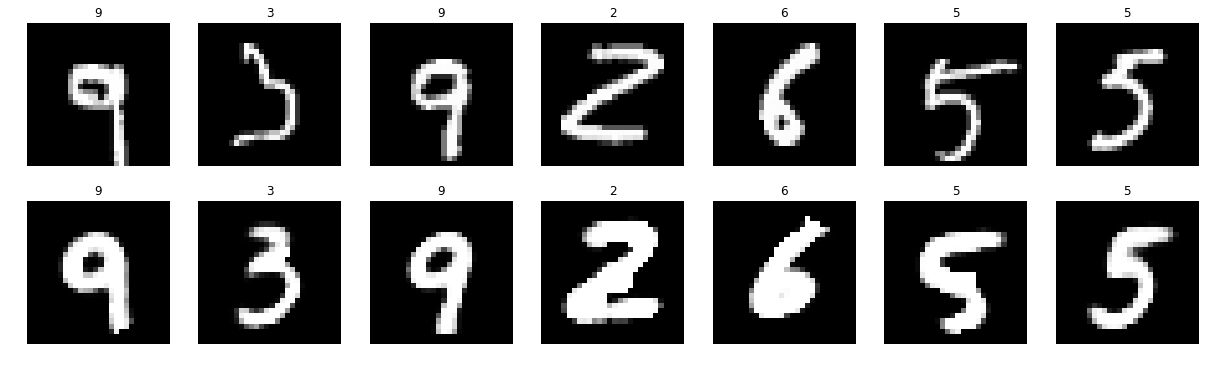

In [14]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time

img_num = 7
k = random.randint(10,100)

imgs = x_test[k:img_num+k].cpu().numpy()
label = y_test[k:img_num+k].cpu().numpy()

y_true = torch.sparse.torch.eye(10).index_select(dim=0, index=y_test[k:img_num+k].cpu().data)
y_true = y_true.cuda()

out,pred_imgs = model(x_test[k:img_num+k],y_true)
pred_label = torch.sqrt(torch.sum(out*out, 2))

pred_imgs = pred_imgs.cpu().detach().numpy()
pred_label = pred_label.cpu().detach().numpy()
pred_label = np.argmax(pred_label,1)

plt.figure("test Image",figsize=(img_num*3,3*2))
for i in range(img_num):
    index = i
    img = imgs[index]
    title = label[index]
    img = img.reshape([28, 28])
    
    plt.subplot(2,img_num,i+1)
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
for i in range(img_num):
    index = i
    img = pred_imgs[index]
    plt.subplot(2,img_num,i+img_num+1)
    
    title = pred_label[index]
    img = img.reshape([28, 28])
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
filename = 'r1'+str(time.time())+'.jpg'
plt.savefig(filename)
plt.show()

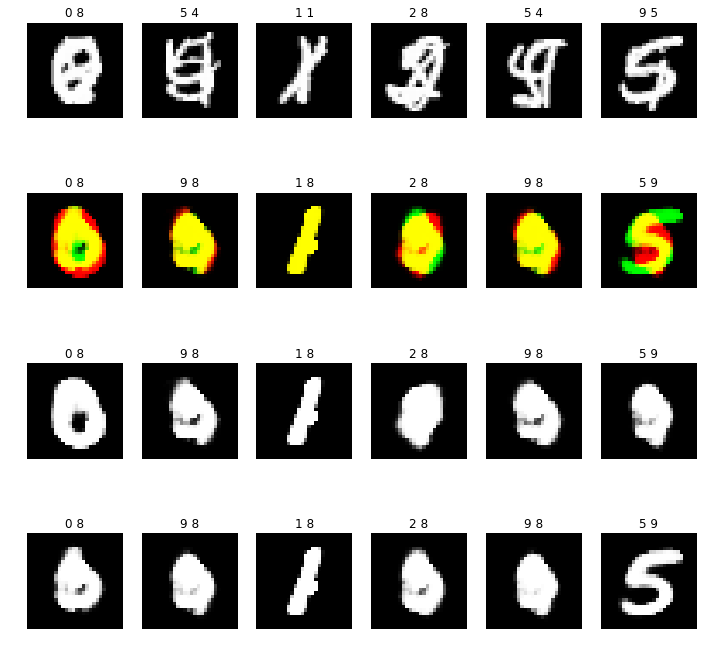

In [21]:
import random
k = random.randint(10,100)

img_num = 6
imgs = (torch.max(x_test[:img_num],x_test[k:img_num+k])).cpu().numpy()

label1 = (y_test[:img_num]).cpu().numpy()
label2 = (y_test[k:img_num+k]).cpu().numpy()

y_true1 = torch.sparse.torch.eye(10).index_select(dim=0, index=y_test[:img_num].cpu().data)
y_true1 = y_true1.cuda()

y_true2 = torch.sparse.torch.eye(10).index_select(dim=0, index=y_test[k:img_num+k].cpu().data)
y_true2 = y_true2.cuda()

data = torch.tensor(imgs,dtype=torch.float,device=DEVICE)

is_overlap = True
out1,pred_imgs1 = model(data,y_true1)
out2,pred_imgs2 = model(data,y_true2)
is_overlap = False

pred_label1 = torch.sqrt(torch.sum(out1*out1, 2))
pred_label2 = pred_label1


pred_imgs1 = pred_imgs1.cpu().detach().numpy()
pred_imgs2 = pred_imgs2.cpu().detach().numpy()

pred_label1 = pred_label1.cpu().detach().numpy()
pred_label2 = pred_label2.cpu().detach().numpy()

pred_label1 = np.argsort(pred_label1,1)[:,-1]
pred_label2 =np.argsort(pred_label2,1)[:,-2]

pred_imgs3 = np.zeros_like(pred_imgs1)

pred_imgs = np.stack((pred_imgs1,pred_imgs2,pred_imgs3),1)
pred_imgs = pred_imgs.transpose(0,3,4,1,2).squeeze(4)


plt.figure("test Image",figsize=(img_num*2,6*2))
for i in range(img_num):
    index = i
    img = imgs[index]
    title = str(label1[index])+" "+str(label2[index])
    img = img.reshape([28, 28])
    
    plt.subplot(4,img_num,i+1)
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
for i in range(img_num):
    index = i
    
    plt.subplot(4,img_num,i+img_num+1)
    title = str(pred_label1[index])+" "+str(pred_label2[index])
    
    img = pred_imgs[index]
    plt.imshow(img)
    plt.axis('off') 
    plt.title(title)
    
    img1 = pred_imgs1[index]
    img1 = img1.reshape([28, 28])    
    plt.subplot(4,img_num,i+2*img_num+1)
    plt.imshow(img1,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
    img2 = pred_imgs2[index]
    img2 = img2.reshape([28, 28])    
    plt.subplot(4,img_num,i+3*img_num+1)
    plt.imshow(img2,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)


    
filename = 'r2'+str(time.time())+'.jpg'
plt.savefig(filename)    
plt.show()